## Investment Analytics - Irene - graph creation-knn-louvain-algo-idea1

In [49]:
import neo4j

import csv

import math
import numpy as np
import pandas as pd

import psycopg2
import matplotlib.pyplot as plt

## Supporting code

In [2]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))
session = driver.session(database="neo4j")

In [3]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)

In [4]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

In [5]:
def my_neo4j_number_nodes_relationships():
    "print the number of nodes and relationships"
   
    
    query = """
        match (n) 
        return n.name as node_name, labels(n) as labels
        order by n.name
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_nodes = df.shape[0]
    
    
    query = """
        match (n1)-[r]->(n2) 
        return n1.name as node_name_1, labels(n1) as node_1_labels, 
            type(r) as relationship_type, n2.name as node_name_2, labels(n2) as node_2_labels
        order by node_name_1, node_name_2
    """
    
    df = my_neo4j_run_query_pandas(query)
    
    number_relationships = df.shape[0]
    
    print("-------------------------")
    print("  Nodes:", number_nodes)
    print("  Relationships:", number_relationships)
    print("-------------------------")


## Load data from website

In [6]:
input_data = pd.read_csv("https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/stocks/stock_prices.csv")
display(input_data.shape)
display(input_data.columns.tolist())
display(input_data.Date)

(9180, 8)

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name']

0       2021-05-05
1       2021-05-06
2       2021-05-07
3       2021-05-10
4       2021-05-11
           ...    
9175    2021-09-03
9176    2021-09-07
9177    2021-09-08
9178    2021-09-09
9179    2021-09-10
Name: Date, Length: 9180, dtype: object

In [7]:
len(input_data.Name.unique())

102

## Use dataframe to create graphs in neo4j

### Check the starting graph status

In [8]:
my_neo4j_wipe_out_database()

In [9]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 0
  Relationships: 0
-------------------------


### Create initial nodes and tradeing_day relationships

In [10]:
def trade_neo4j_create_nodes_relationships(input_row):
    "create a node for each company name, and connect the trading data to the company"
    
    query = """
    
    MERGE (s: Stock{name:$input_row.Name})
    CREATE (s)-[:TRADING_DAY]->(:StockTradingDay{date: date($input_row.Date), close:toFloat($input_row.Close),
                volume: toFloat($input_row.Volume)});
    
    """
    
    session.run(query, input_row=input_row)

In [11]:
for i in range(len(input_data)):
    trade_neo4j_create_nodes_relationships(input_data.iloc[i,:].to_dict())

In [12]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 9282
  Relationships: 9180
-------------------------


### Create linked dates relationships

In [ ]:
def trade_neo4j_create_linked_date_list():
    "create the linked relationship among trade dates for each company"
    
    query = """
    
    MATCH (s:Stock)-[:TRADING_DAY]->(day)
    WITH s, day
    ORDER BY day.date ASC
    WITH s, collect(day) as nodes, collect(day.close) as closes, collect(day.volume) as volumes
    SET s.close_array = closes
    SET s.volume_array = volumes
    WITH nodes
    UNWIND range(0, size(nodes)-2) as idx 
    WITH nodes[idx] as first, nodes[idx+1] as second
    CREATE (first) -[:NEXT_DAY]->(second)
    WITH DISTINCT 'linked dates done' AS result
    RETURN result
    
    """
    
    return session.run(query)

In [ ]:
initial_graph_res = trade_neo4j_create_linked_date_list()
result = initial_graph_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

In [ ]:
my_neo4j_number_nodes_relationships()

## Idea 1: construct price and volume correlation similarity-based stock communities,  then we can choose top performers from different communities as a portfolio, which maximize the return but minimize the risks

### Create pearson similarity based on prices among stock nodes

In [16]:
def stream_price_pearson_similarity():
    # just calculate the similarity between stocks using price, we can pull the query result and put in pandas
    # but this function does not change the graph and does not write in the property of nodes or relationships
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Stock', '*', {nodeProperties:'close_array'})"
    session.run(query)
    
    query = '''
    CALL gds.knn.stream('ds_graph', {
    topK: 3,
    similarityCutoff: 0.2,
    nodeProperties:{close_array:'Pearson'}
    })
    YIELD node1, node2, similarity
    RETURN gds.util.asNode(node1).name as Stock1,
            gds.util.asNode(node2).name as Stock2,
            similarity
    ORDER BY similarity DESCENDING, Stock1, Stock2
    '''
    return session.run(query)

In [17]:
price_pearson_similarity_res = stream_price_pearson_similarity()
result = price_pearson_similarity_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,Stock1,Stock2,similarity
0,GOOG,GOOGL,0.994631
1,GOOGL,GOOG,0.994631
2,ISRG,MSFT,0.992927
3,MSFT,ISRG,0.992927
4,ADBE,MSFT,0.992041
...,...,...,...
301,JD,BKNG,0.734955
302,EA,SIRI,0.726147
303,MDLZ,SIRI,0.705584
304,EA,JD,0.696266


In [18]:
def add_price_pearson_similarity():
    # add pearson_similarity as pair-wise score between stock nodes
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Stock', '*', {nodeProperties:'close_array'})"
    session.run(query)
    
    query = '''
    CALL gds.knn.write('ds_graph', {
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'price_similarity_score',
        topK: 3,
        similarityCutoff: 0.2,
        nodeProperties:{close_array:'Pearson'}
      })
      YIELD nodesCompared, relationshipsWritten
        '''
    return session.run(query)

In [19]:
# add price pearson_similarity on stock nodes
add_price_similarity_res = add_price_pearson_similarity()
result = add_price_similarity_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,nodesCompared,relationshipsWritten
0,102,306


In [20]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 9282
  Relationships: 18564
-------------------------


### Create volume based similarity among stock nodes

In [21]:
def stream_volume_pearson_similarity():
    # just calculate the similarity between stocks using volume, we can pull the query result and put in pandas
    # but this function does not change the graph and does not write in the property of nodes or relationships
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Stock', '*', {nodeProperties:'volume_array'})"
    session.run(query)
    
    query = '''
    CALL gds.knn.stream('ds_graph', {
    topK: 3,
    similarityCutoff: 0.2,
    nodeProperties:{volume_array:'pearson'}
    })
    YIELD node1, node2, similarity
    RETURN gds.util.asNode(node1).name as Stock1,
            gds.util.asNode(node2).name as Stock2,
            similarity
    ORDER BY similarity DESCENDING, Stock1, Stock2
    '''
    return session.run(query)

In [22]:
volume_similarity_res = stream_volume_pearson_similarity()
result = volume_similarity_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,Stock1,Stock2,similarity
0,GOOG,GOOGL,0.915292
1,GOOGL,GOOG,0.915292
2,AMD,XLNX,0.895629
3,XLNX,AMD,0.895629
4,NXPI,ORLY,0.887593
...,...,...,...
301,MRNA,MCHP,0.628009
302,DOCU,LULU,0.625812
303,LULU,DOCU,0.625812
304,MU,XLNX,0.625083


In [23]:
def add_volume_pearson_similarity():
    # add pearson_similarity as pair-wise score between stock nodes
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = "CALL gds.graph.project('ds_graph', 'Stock', '*', {nodeProperties:'volume_array'})"
    session.run(query)
    
    query = '''
    CALL gds.knn.write('ds_graph', {
        writeRelationshipType: 'SIMILAR',
        writeProperty: 'volume_similarity_score',
        topK: 3,
        similarityCutoff: 0.2,
        nodeProperties:{volume_array:'Pearson'}
      })
      YIELD nodesCompared, relationshipsWritten
        '''
    return session.run(query)

In [24]:
# add volume pearson_similarity on stock nodes
add_volume_similarity_res = add_volume_pearson_similarity()
result = add_volume_similarity_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,nodesCompared,relationshipsWritten
0,102,306


In [25]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 9282
  Relationships: 18870
-------------------------


### Use both price and voulme similarity to create community use Louvain Modularity Algorithm

In [30]:
def stream_price_volume_louvain_modularity_property():
    # add community ids as node properties using louvain modularity detection based on similarity scores
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = '''
    CALL gds.graph.project('ds_graph', 'Stock', '*', 
            {nodeProperties: ['close_array', 'volume_array'],
            relationshipProperties:['price_similarity_score', 'volume_similarity_score']})
    '''
    session.run(query)
    
    query = '''
    CALL gds.louvain.stream('ds_graph') 
    YIELD nodeId, communityId, intermediateCommunityIds
    RETURN gds.util.asNode(nodeId).name AS Ticker, communityId as Community
    ORDER BY Ticker
    '''
    return session.run(query)

In [31]:
stream_price_volume_community_res = stream_price_volume_louvain_modularity_property()
result = stream_price_volume_community_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,Ticker,Community
0,AAPL,45
1,ADBE,45
2,ADI,45
3,ADP,19
4,ADSK,19
...,...,...
97,WBA,70
98,WDAY,45
99,XEL,19
100,XLNX,101


In [38]:
def add_price_volume_louvain_modularity_property():
    # add community ids as node properties using louvain modularity detection based on similarity scores
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    query = '''
    CALL gds.graph.project('ds_graph', 'Stock', '*', 
        {nodeProperties: ['close_array', 'volume_array'],
        relationshipProperties:['price_similarity_score','volume_similarity_score']})
        '''
    session.run(query)
    
    query = '''
    CALL gds.louvain.write('ds_graph', {  
    writeProperty:'price_volume_louvain_community'
    })
    YIELD communityCount, modularity, modularities
    '''
    return session.run(query)

In [39]:
# add community ids as node properties using louvain modularity detection based on price + volume similarity scores
add_price_volume_community_res = add_price_volume_louvain_modularity_property()
result = add_price_volume_community_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,communityCount,modularity,modularities
0,5,0.348135,"[0.3354479046520569, 0.3481353325643983]"


In [40]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 9282
  Relationships: 18870
-------------------------


### Add slope property by calculating the slope in pandas, and update the node property in neo4j


In [41]:
stock_slope_df = input_data.groupby(['Name'])['Close']\
                    .apply(lambda x: x.diff().sum()/len(x)).rename('Slope').to_frame().reset_index()

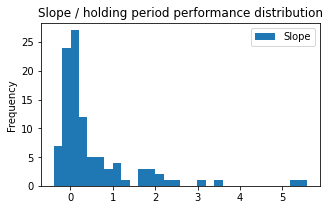

In [53]:
stock_slope_df.plot.hist(bins=30, figsize=(5,3))
plt.title('Slope / holding period performance distribution')
plt.show()

In [42]:
def add_slope_property_to_nodes(stock_slope_pair):
    
    query = '''
    MATCH (s: Stock)
    WHERE s.name = $stock_slope_pair.Name
    SET s.slope = $stock_slope_pair.Slope
    '''
    session.run(query, stock_slope_pair=stock_slope_pair)
    # IN: note: the return is optional, and it is only useful to note that the process is done here, 
    # IN: given we do not want to return the 'done' note for each updated node, the return is not needed

In [43]:
for i in range(len(stock_slope_df)):
    add_slope_property_to_nodes(stock_slope_df.iloc[i,:].to_dict())

In [44]:
my_neo4j_number_nodes_relationships()

-------------------------
  Nodes: 9282
  Relationships: 18870
-------------------------


### Pick the top five performing stocks from each community (ranked by holding period return / slope)

In [56]:
def pick_top_stocks_per_community(top_num):
    
    query = '''
    MATCH (s:Stock)
    WITH s.price_volume_louvain_community AS Community, s.slope AS slope, s.name AS ticker
    ORDER BY slope DESC
    RETURN Community, collect(ticker)[..$top_num] as Potential_investments
    
    '''
    return session.run(query, top_num = top_num)
    

In [57]:
top_stocks_per_community_res = pick_top_stocks_per_community(5)
result = top_stocks_per_community_res
pd.DataFrame([r.values() for r in result], columns=result.keys())

,Community,Potential_investments
0,45,"[GOOGL, GOOG, MRNA, ASML, ISRG]"
1,19,"[MELI, AMZN, IDXX, LULU, COST]"
2,101,"[XLNX, AMD, KDP, KHC, PCAR]"
3,4,"[PTON, BIIB, ZM, SIRI, CERN]"
4,70,"[EA, JD, CHKP, FOXA, FOX]"
